Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. She therefore went and talked to the international team in charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish- speaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised cause the test is negative. I.e., it appears that the non-localized translation was doing better!

You are asked to:
* Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
* Explain why that might be happening. Are the localized translations really worse?
* If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

In [73]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from __future__ import division

In [4]:
dft = pd.read_csv("test_table.csv", parse_dates=True)

In [5]:
dfu = pd.read_csv("user_table.csv", parse_dates=True)

In [6]:
dft.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [7]:
dfu.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [8]:
dft.describe()

,user_id,conversion,test
count,453321.000000,453321.000000,453321.000000
mean,499937.514728,0.049579,0.476446
std,288665.193436,0.217073,0.499445
min,1.000000,0.000000,0.000000
25%,249816.000000,0.000000,0.000000
50%,500019.000000,0.000000,0.000000
75%,749522.000000,0.000000,1.000000
max,1000000.000000,1.000000,1.000000


In [66]:
# merge in customer data, will need country
df = pd.merge(dft, dfu)

In [67]:
# group A: control (Spaniard)
# group B: local writers versions
A = df[df.test == 0]
B = df[df.test == 1]

In [51]:
# conversion rate across all control records
A[A.conversion==1].size/A.size

0.055155571864205187

In [52]:
# conversion rate across all localized-translation records
B[B.conversion==1].size/B.size

0.043411161678422794

In [37]:
latam = df[df.country != 'Spain']   # latin america records only
spain = df[df.country == 'Spain']   # spain records only
latamA = latam[latam.test == 0]
latamB = latam[latam.test == 1]
spainA = spain[spain.test == 0]
spainB = spain[spain.test == 1]  # should be empty

"A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country." This appears true in aggregate. Would be worth analyzing country by country.

In [57]:
# conversion rate for Spaniard words in Spain
spainA[spainA.conversion==1].size/spainA.size

0.079718821212004173

In [60]:
# conversion rate for non-spain group A (Spaniard)
latamA[latamA.conversion==1].size/latamA.size

0.048291790557495239

In [55]:
# conversion rate for non-spain group B (Local)
latamB[latamB.conversion==1].size/latamB.size

0.043411161678422794

"It appears that the non-localized translation was doing better!" It does appear that way. 

In [61]:
LSconv0 = latamA[latamA.conversion == 0]
LSconv1 = latamA[latamA.conversion == 1]
Lconv0 = latamB[latamB.conversion == 0]
Lconv1 = latamB[latamB.conversion == 1]

In [62]:
m = [[cno.size, cconv.size],[locno.size, locconv.size]]
m

[[2116344, 107388], [2476884, 112404]]

In [68]:
# Convert categorical variables into numbers
from sklearn.preprocessing import LabelEncoder
for feat in ['browser_language', 'country', 'browser', 'ads_channel', 'device', 'source', 'sex']:
    lbl_enc = LabelEncoder()
    lbl_enc.fit(df[feat])
    df[feat] = lbl_enc.transform(df[feat])

df.head()

/Users/s1/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/Users/s1/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,1,1,1,0,3,1,0,1,32,14
1,497851,2015-12-04,0,1,1,3,3,0,1,1,21,9
2,848402,2015-12-04,0,1,1,2,1,0,0,1,34,14
3,290051,2015-12-03,0,0,2,2,0,0,1,0,22,9
4,548435,2015-11-30,0,1,1,3,2,0,1,1,19,9


In [69]:
# Fit a Random Forest and check feature importance
from sklearn.ensemble import RandomForestClassifier
features = ['browser_language', 'country', 'browser', 'ads_channel', 'device', 'source', 'sex', 'age']
model = RandomForestClassifier()
model.fit(df[features], df['test'])
feature_importances = model.feature_importances_
importance = pd.Series(feature_importances, index = features)

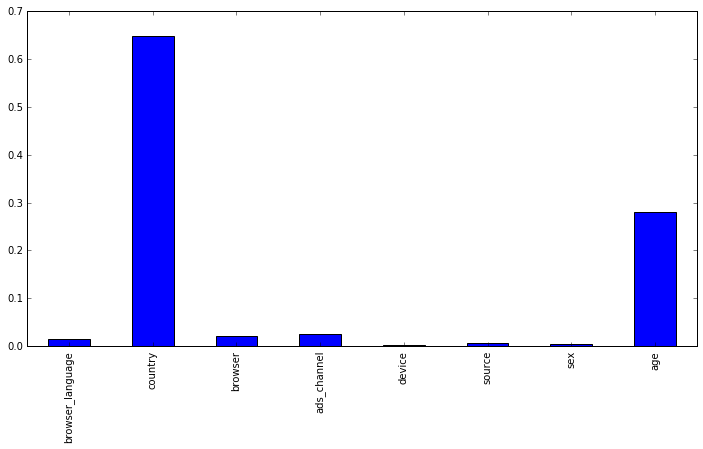

In [74]:
plt.figure(figsize=(12, 6))
importance.plot(kind = 'bar')

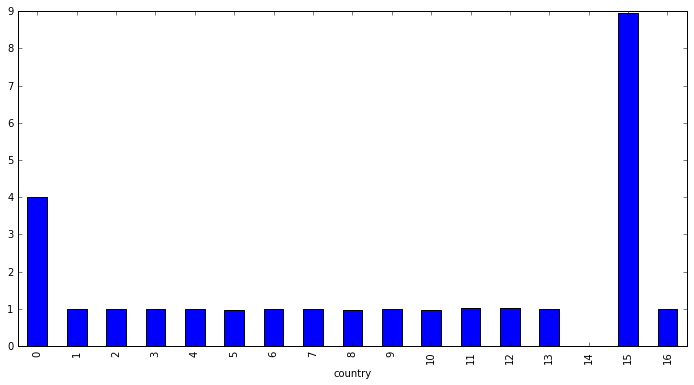

In [75]:
plt.figure(figsize=(12, 6))
ratios=df[df['test']==1].groupby(['country'])['conversion'].count()/df[df['test']==0].groupby(['country'])['conversion'].count()
ratios.plot(kind='bar')
plt.show()

In [83]:
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,1,1,1,0,3,1,0,1,32,14
1,497851,2015-12-04,0,1,1,3,3,0,1,1,21,9
2,848402,2015-12-04,0,1,1,2,1,0,0,1,34,14
3,290051,2015-12-03,0,0,2,2,0,0,1,0,22,9
4,548435,2015-11-30,0,1,1,3,2,0,1,1,19,9


In [91]:
df = pd.merge(dft, dfu)
for country in latam['country'].unique():
    print str("\n")+country
    print(stats.ttest_ind(df[(df['test']==0) & (df['country']==country)]['conversion'], df[(df['test']==1) & (df['country']==country)]['conversion'], equal_var = False))
    print('Conversion ratio, control:')
    print(df[(df['test']==0) & (df['country']==country)]['conversion'].mean())
    print('Conversion ratio, test:')
    print(df[(df['test']==1) & (df['country']==country)]['conversion'].mean())


Mexico
Ttest_indResult(statistic=-1.3866735952325449, pvalue=0.16554372211039645)
Conversion ratio, control:
0.0494946191344
Conversion ratio, test:
0.0511863088292

Venezuela
Ttest_indResult(statistic=0.56261424690935702, pvalue=0.57370152343872549)
Conversion ratio, control:
0.0503436745309
Conversion ratio, test:
0.048978308708

Bolivia
Ttest_indResult(statistic=0.35995817724402418, pvalue=0.71888524684510746)
Conversion ratio, control:
0.0493693693694
Conversion ratio, test:
0.0479009687836

Colombia
Ttest_indResult(statistic=0.79999178223708245, pvalue=0.42371907413141152)
Conversion ratio, control:
0.0520894861193
Conversion ratio, test:
0.0505709624796

Uruguay
Ttest_indResult(statistic=-0.15134316107212104, pvalue=0.87976397365142245)
Conversion ratio, control:
0.0120481927711
Conversion ratio, test:
0.0129066953482

El Salvador
Ttest_indResult(statistic=1.1549940887832975, pvalue=0.2481266743266678)
Conversion ratio, control:
0.0535540408958
Conversion ratio, test:
0.04794688

When we look at the conversion ratios country by country, the pvalues show that there is no significant difference between translations A and B. 

A data scientist must question all aspects of the case presented, taking nothing for granted. We can begin with qualitative analysis, but must ultimately attempt to ground any theories through experimental testing, backed by rigorous quantitative analysis of what "the data suggest." 

"Spain based users have a much higher conversion rate". This is in fact seen in the data with some confidence. Note however that there can be be many aspects of the real world that account for this. Non-Spain users live in different countries, with different cultures, different economies. In some of those countries its winter when its summer in Spain.  We could hypothesize and gather additional data, like ping times, but working with the presented case, we can at least consider gender, country, etc. We should model the conversion data to determine the features that drive conversion, then see if those are different in Spain vs. Latin America. 

The experiment encompassed only 5 days and not an entire week. The latin american countries are in very different time zones. Its possible the data for Spain include 12 hours of weekend. 

"It appears the non-localized translation was doing better". 